In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm
from PIL import Image
import os
import cv2

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/Scin Cancer/ISIC 2016/Training/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/Scin Cancer/ISIC 2016/Training/malignant',224))
benign_val = np.array(Dataset_loader('/content/drive/MyDrive/Scin Cancer/ISIC 2016/Validation/benign',224))
malign_val = np.array(Dataset_loader('/content/drive/MyDrive/Scin Cancer/ISIC 2016/Validation/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/Scin Cancer/ISIC 2016/Testing/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/Scin Cancer/ISIC 2016/Testing/malignant',224))

100%|██████████| 75/75 [00:19<00:00,  3.89it/s]


In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_val_label = np.zeros(len(benign_val))
malign_val_label = np.ones(len(malign_val))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train, benign_val, malign_val), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label, benign_val_label, malign_val_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(Y_train)
print(counter)

Counter({0.0: 727, 1.0: 173})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
sm = SMOTE(random_state=42)
    
train_rows=len(X_train)
test_rows=len(X_test)
X_train = X_train.reshape(train_rows,-1)
X_test = X_test.reshape(test_rows,-1)
print(X_train.shape)
print(X_test.shape)

X_train, Y_train = sm.fit_resample(X_train, Y_train)

(1454, 150528)
(379, 150528)


TP 7 FP 31 FN 68 TN 273
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       304
         1.0       0.18      0.09      0.12        75

    accuracy                           0.74       379
   macro avg       0.49      0.50      0.49       379
weighted avg       0.68      0.74      0.70       379

Accuracy of Support vector Machines classifier on test set: 73.88

[[273  31]
 [ 68   7]]
Time took for training and predicting the results 637.14 in seconds

Recall  0.09333333333333334
F1- Score   0.12389380530973451


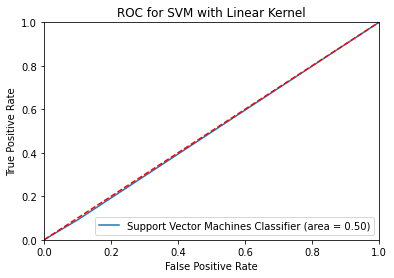

Area Under the Curve  0.49567982456140347


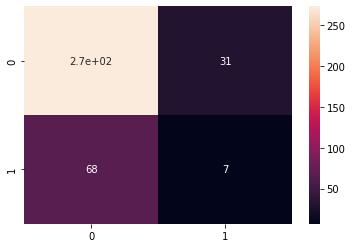

In [ ]:
def SupportVectorMachines(train, label, test, label_test):
    start = time.time()

    model1 = svm.SVC(kernel='linear', C=0.3)
    model1.fit(train, label)

    pred1 = model1.predict(test)

    end = time.time()

    confusion_mat1 = confusion_matrix(label_test, pred1)

    def get_confusion_matrix_values2(label_test, pred1):
        cm1 = confusion_matrix(label_test, pred1)
        return (cm1[0][0], cm1[0][1], cm1[1][0], cm1[1][1])

    TN1, FP1, FN1, TP1 = get_confusion_matrix_values2(label_test, pred1)

    denom1 = TP1 + FP1

    print('TP', TP1, 'FP', FP1, 'FN', FN1, 'TN', TN1)
    print(classification_report(label_test, pred1))

    print('Accuracy of Support vector Machines classifier on test set: {:.2f}\n'.format(
        float(confusion_mat1[0, 0] + confusion_mat1[1, 1]) * 100 / confusion_mat1.sum()))
    print(confusion_mat1)

    print('Time took for training and predicting the results {0:.5} in seconds\n'.format(float(end - start)))

    recall1 = float(confusion_mat1[1, 1] / (confusion_mat1[1, 1] + confusion_mat1[1, 0]))
    prec1 = float(confusion_mat1[1, 1] / (confusion_mat1[1, 1] + confusion_mat1[0, 1]))

    f_score1 = (2 * recall1 * prec1) / (recall1 + prec1)

    # print('real prec', prec)

    print('Recall ', recall1)

    print('F1- Score  ', f_score1)

    roc_auc4 = roc_auc_score(label_test, pred1)

    fpr4, tpr4, thresholds4 = roc_curve(label_test, pred1)
    plt.figure()
    plt.plot(fpr4, tpr4, label='Support Vector Machines Classifier (area = %0.2f)' % roc_auc4)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for SVM with Linear Kernel')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC_SVM')
    plt.show()

    print('Area Under the Curve ', roc_auc4)
    sns.heatmap(confusion_mat1, annot=True)
    plt.savefig('SVM.png')
    plt.show()


SupportVectorMachines(X_train, Y_train, X_test, Y_test)